# Sales Assistant Bot with LangGraph and Bedrock Session Management

## Introduction

This notebook demonstrates how to build a sales assistant bot using LangGraph, a powerful framework for creating stateful, multi-step conversational AI applications. The example focuses on a shoe shopping assistant that helps users find their perfect pair of shoes through an interactive conversation.

Key features demonstrated in this notebook:

1. **LangGraph Integration**: Shows how to use LangGraph with Amazon Bedrock to create a conversation flow with multiple steps and tools.

2. **Amazon Bedrock Session Management**: Implements state persistence using Bedrock, allowing the bot to maintain context and resume conversations where they left off.

3. **Stateful Conversations**: Demonstrates how to maintain user preferences and conversation history across multiple interactions.

4. **Real-world Use Case**: Implements a practical shoe shopping assistant that:
   - Asks relevant questions about user preferences
   - Provides personalized recommendations
   - Maintains context throughout the shopping experience

This example serves as a template for developers looking to build sophisticated conversational applications with state management capabilities.

## Setup 

Let's start with installing required packages.

In [1]:
%pip install -U langgraph_checkpoint_aws

Note: you may need to restart the kernel to use updated packages.


Now create Bedrock client that is used to configure LLM in LangChain to use Bedrock

In [3]:
from langgraph_checkpoint_aws.saver import BedrockSessionSaver
import boto3

# ---- ⚠️ Update region for your AWS setup ⚠️ ----
bedrock_client = boto3.client("bedrock-runtime", region_name="us-west-2")

To integrate LLM from Amazon Bedrock, we are going to use ChatBedrockConverse class of LangChain. We also need to use bedrock_client to connect to Bedrock.

In [4]:
from langchain_aws import ChatBedrockConverse

llm = ChatBedrockConverse(
    model="anthropic.claude-3-sonnet-20240229-v1:0",
    # model="anthropic.claude-3-5-sonnet-20240620-v1:0",
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)

## Tools

This section contains the custom tools and utilities needed for our sales assistant bot. These tools handle various functionalities such as searching for shoes, managing user preferences, and processing orders. 

The tools are designed to be modular and reusable, making it easy to extend or modify the bot's capabilities. Each tool follows a consistent interface pattern, accepting specific inputs and returning structured outputs that can be used in the conversation flow.

In [5]:
from langchain_core.tools import tool
import sqlite3


@tool
def search_shoes(preference):
    """
    Search for shoes based on user preferences and interests.
    This tool helps find shoes that match specific activities or styles like running, hiking, casual wear, or basketball.

    Args:
    preference(str): User preference

    """
    conn = sqlite3.connect("shoe_store.db")
    cursor = conn.cursor()

    # Search in category and features
    query = """
    SELECT * FROM shoes 
    WHERE LOWER(category) LIKE LOWER(?) 
    OR LOWER(features) LIKE LOWER(?)
    """
    search_term = f"%{preference}%"
    cursor.execute(query, (search_term, search_term))

    results = cursor.fetchall()
    conn.close()

    return results

In [ ]:
import datetime
@tool
def add_to_cart(
    user_id,
    shoe_id,
    size,
    quantity=1,
):
    """
    Add to cart
    This tool helps user to add shoes to the cart

    Args:
    user_id(int): User id
    shoe_id(int): Shoe id
    size(str): Shoe size
    quantity(int, optional): Quantity
    size()

    """
    conn = sqlite3.connect("shoe_store.db")
    cursor = conn.cursor()

    try:
        # Check if shoe exists and has enough stock
        cursor.execute("SELECT stock FROM shoes WHERE id = ?", (shoe_id,))
        result = cursor.fetchone()
        if not result:
            conn.close()
            return False, "Shoe not found"

        current_stock = result[0]
        if current_stock < quantity:
            conn.close()
            return False, f"Not enough stock. Available: {current_stock}"

        # Check if item already in cart
        cursor.execute(
            """
        SELECT id, quantity FROM shopping_cart 
        WHERE user_id = ? AND shoe_id = ? AND size = ?
        """,
            (user_id, shoe_id, size),
        )
        cart_item = cursor.fetchone()

        added_at = datetime.now().strftime("%Y-%m-%d %H:%M:%S") 

        if cart_item:
            # Update existing cart item
            new_quantity = cart_item[1] + quantity
            cursor.execute(
                """
            UPDATE shopping_cart 
            SET quantity = ?, added_at = ?
            WHERE id = ?
            """,
                (new_quantity, added_at, cart_item[0]),
            )
        else:
            # Add new cart item
            cursor.execute(
                """
            INSERT INTO shopping_cart (user_id, shoe_id, quantity, size, added_at)
            VALUES (?, ?, ?, ?, ?)
            """,
                (user_id, shoe_id, quantity, size, added_at),
            )

        # Update shoe stock
        cursor.execute(
            """
        UPDATE shoes 
        SET stock = stock - ? 
        WHERE id = ?
        """,
            (quantity, shoe_id),
        )

        conn.commit()
        return True, "Item added to cart successfully"

    except Exception as e:
        return False, f"Error adding to cart: {str(e)}"
    finally:
        conn.close()

In [7]:
tools = [search_shoes, add_to_cart]

In [8]:
llm_with_tools = llm.bind_tools(tools)

## Graph Setup and Prompt Configuration

This section sets up the core components of our LangGraph chatbot. We define the state management structure and configure the primary conversation prompt. Key elements include:

- State definition for managing conversation messages
- Graph initialization using StateGraph
- Configuration of the primary assistant prompt that defines the bot's personality and purpose
- Integration of the language model with custom tools for enhanced functionality

The prompt is designed to create a friendly shopping assistant that guides users through the shoe purchasing process by asking relevant questions about their preferences.

In [9]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, MessagesState
from langgraph.graph.message import add_messages
from datetime import datetime, timezone


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful and friendly chatbot who can help users to purchase shoes. "
             "Ask questions about user preferences and interests "
             "Ask questions that can help user to add shoes to the cart "
        ),
        ("placeholder", "{messages}"),
    ]
)

runnable_with_tools = primary_assistant_prompt | llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [runnable_with_tools.invoke(state)]}

graph_builder.add_node("chatbot", chatbot)

In [10]:
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools)
graph_builder.add_node("tools", tool_node)

In [11]:
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {"tools": "tools", "__end__": "__end__"},
)

This section defines the basic flow of our conversation graph by establishing the connections between different components. The graph is constructed with two simple edges:
1. From START to the chatbot
2. From tools to the chatbot

> **Important Note**: At this stage, the graph operates without any persistent memory. This means that each conversation starts fresh, without any knowledge of previous interactions. In the following sections, we'll enhance this basic structure by adding session management capabilities using Bedrock to maintain conversation state across interactions.


In [12]:
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

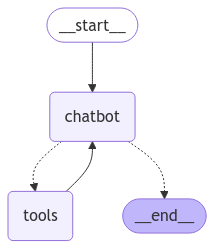

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

This section implements a simple interactive conversation loop that allows users to chat with our sales assistant. The loop continues until the user types 'quit', 'exit', or 'q' to end the conversation.

> **Important Limitation**: In this basic implementation, each time a user starts a new conversation (by running this cell again), all previous conversation history is lost. The bot has no memory of past interactions, preferences, or context from previous conversations. This means:
> - Every conversation starts fresh
> - Previously discussed preferences need to be repeated
> - Shopping cart information is not preserved
> 
> We'll address this limitation in the next section by implementing session management with Bedrock to maintain conversation state across sessions.


In [ ]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        print(event)
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

In [15]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph_checkpoint_aws.saver import BedrockSessionSaver

session_saver = BedrockSessionSaver(
    region_name="us-west-2",
)
graph = graph_builder.compile(checkpointer=session_saver)

In [16]:
client = session_saver.session_client.client

In [18]:
session_id = client.create_session()["sessionId"]
print("Using SessionId:", session_id)

Using SessionId: fce22af2-f5b3-481c-a217-f34444b08a1d


In [19]:
config = {"configurable": {"thread_id": session_id}}

In [20]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}, config):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

Assistant: Great, I'd be happy to help you find some shoes! To get started, what kind of activities or styles are you interested in? Are you looking for running shoes, hiking boots, casual sneakers, dress shoes, or something else? Knowing your preferences will help me search for the right options.
Assistant: [{'type': 'text', 'text': "Okay, let's search for some good running shoes based on your preference:"}, {'type': 'tool_use', 'name': 'search_shoes', 'input': {'preference': 'running'}, 'id': 'tooluse_PSkWbFo6TPe5fnSx9sHmqg'}]
Assistant: [[2, "New Balance Running Off", "New Balance", "Running", "Cushioning, Stability", 121.42, 8.0, "Gainsboro", 40], [4, "Nike Running Father", "Nike", "Running", "Lightweight, Stability, Breathable", 104.57, 9.2, "MediumTurquoise", 13], [19, "Nike Running Require", "Nike", "Running", "Cushioning, Breathable, Stability", 176.51, 8.9, "NavajoWhite", 42], [21, "Adidas Running Window", "Adidas", "Running", "Stability, Lightweight, Breathable, Cushioning", 

### History

In [21]:
for i in graph.get_state_history(config, limit=3):
    print(i)

StateSnapshot(values={'messages': [HumanMessage(content='I am looking to by shoes', additional_kwargs={}, response_metadata={}, id='e003cd3c-7994-4eb6-8314-d8d751dee852'), AIMessage(content="Great, I'd be happy to help you find some shoes! To get started, what kind of activities or styles are you interested in? Are you looking for running shoes, hiking boots, casual sneakers, dress shoes, or something else? Knowing your preferences will help me search for the right options.", additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '9fc25f83-194b-463f-8855-0a4c2022e249', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 10 Mar 2025 10:50:18 GMT', 'content-type': 'application/json', 'content-length': '471', 'connection': 'keep-alive', 'x-amzn-requestid': '9fc25f83-194b-463f-8855-0a4c2022e249'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [1383]}}, id='run-169e28d3-f78d-4e16-8b96-fd42717e4548-0', usage_metadata={'input_tokens': 440, 'outpu

### Replaying

Replaying allows us to revisit and reproduce an agent's past actions, up to and including a specific step (checkpoint).

In [22]:
all_checkpoints = []
for state in graph.get_state_history(config):
    all_checkpoints.append(state)

In [23]:
all_checkpoints

[StateSnapshot(values={'messages': [HumanMessage(content='I am looking to by shoes', additional_kwargs={}, response_metadata={}, id='e003cd3c-7994-4eb6-8314-d8d751dee852'), AIMessage(content="Great, I'd be happy to help you find some shoes! To get started, what kind of activities or styles are you interested in? Are you looking for running shoes, hiking boots, casual sneakers, dress shoes, or something else? Knowing your preferences will help me search for the right options.", additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '9fc25f83-194b-463f-8855-0a4c2022e249', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 10 Mar 2025 10:50:18 GMT', 'content-type': 'application/json', 'content-length': '471', 'connection': 'keep-alive', 'x-amzn-requestid': '9fc25f83-194b-463f-8855-0a4c2022e249'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [1383]}}, id='run-169e28d3-f78d-4e16-8b96-fd42717e4548-0', usage_metadata={'input_tokens': 440, 'outp

The graph replays previously executed steps before the provided `checkpoint_id`

In [24]:
config_replay = {
    "configurable": {
        "thread_id": session_id,
        "checkpoint_id": "1effd9d7-97bb-67e4-8002-58cd344c5c6f",
    }
}
for event in graph.stream(None, config_replay, stream_mode="values"):
    print(event)

{'messages': [HumanMessage(content='I am looking to by shoes', additional_kwargs={}, response_metadata={}, id='e003cd3c-7994-4eb6-8314-d8d751dee852'), AIMessage(content="Great, I'd be happy to help you find some shoes! To get started, what kind of activities or styles are you interested in? Are you looking for running shoes, hiking boots, casual sneakers, dress shoes, or something else? Knowing your preferences will help me search for the right options.", additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '9fc25f83-194b-463f-8855-0a4c2022e249', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 10 Mar 2025 10:50:18 GMT', 'content-type': 'application/json', 'content-length': '471', 'connection': 'keep-alive', 'x-amzn-requestid': '9fc25f83-194b-463f-8855-0a4c2022e249'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [1383]}}, id='run-169e28d3-f78d-4e16-8b96-fd42717e4548-0', usage_metadata={'input_tokens': 440, 'output_tokens': 65, 'total

### Forking

Forking allows you to revisit an agent's past actions and explore alternative paths within the graph.

In [25]:
config = {
    "configurable": {
        "thread_id": session_id,
        "checkpoint_id": "1effd9d7-97bb-67e4-8002-58cd344c5c6f",
    }
}
graph.update_state(config, {"state": "updated state"})

{'configurable': {'thread_id': 'fce22af2-f5b3-481c-a217-f34444b08a1d',
  'checkpoint_ns': '',
  'checkpoint_id': '1effd9ff-2e06-65ce-8003-3c2c344e1971'}}

In [26]:
config = {
    "configurable": {
        "thread_id": session_id,
        "checkpoint_id": "1effd9ff-2e06-65ce-8003-3c2c344e1971",
    }
}
for event in graph.stream(None, config, stream_mode="values"):
    print(event)

{'messages': [HumanMessage(content='I am looking to by shoes', additional_kwargs={}, response_metadata={}, id='e003cd3c-7994-4eb6-8314-d8d751dee852'), AIMessage(content="Great, I'd be happy to help you find some shoes! To get started, what kind of activities or styles are you interested in? Are you looking for running shoes, hiking boots, casual sneakers, dress shoes, or something else? Knowing your preferences will help me search for the right options.", additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '9fc25f83-194b-463f-8855-0a4c2022e249', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 10 Mar 2025 10:50:18 GMT', 'content-type': 'application/json', 'content-length': '471', 'connection': 'keep-alive', 'x-amzn-requestid': '9fc25f83-194b-463f-8855-0a4c2022e249'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [1383]}}, id='run-169e28d3-f78d-4e16-8b96-fd42717e4548-0', usage_metadata={'input_tokens': 440, 'output_tokens': 65, 'total

### Human in the loop

HIL interaction pattern, allows the graph to stop at specific steps and seek human approval before proceeding. This is important if we have to review specific tool calls.

In [28]:
from typing_extensions import TypedDict, Literal
from langgraph.types import Command, interrupt

def human_review_node(state) -> Command[Literal["call_llm", "run_tool"]]:
    last_message = state["messages"][-1]
    tool_call = last_message.tool_calls[-1]

    # this is the value we'll be providing via Command(resume=<human_review>)
    human_review = interrupt(
        {
            "question": "Is this correct?",
            # Surface tool calls for review
            "tool_call": tool_call,
        }
    )

    review_action = human_review["action"]
    review_data = human_review.get("data")

    # if approved, call the tool
    if review_action == "continue":
        return Command(goto="run_tool")

    # update the AI message AND call tools
    elif review_action == "update":
        updated_message = {
            "role": "ai",
            "content": last_message.content,
            "tool_calls": [
                {
                    "id": tool_call["id"],
                    "name": tool_call["name"],
                    # This the update provided by the human
                    "args": review_data,
                }
            ],
            # This is important - this needs to be the same as the message you replacing!
            # Otherwise, it will show up as a separate message
            "id": last_message.id,
        }
        return Command(goto="run_tool", update={"messages": [updated_message]})

    # provide feedback to LLM
    elif review_action == "feedback":
        # NOTE: we're adding feedback message as a ToolMessage
        # to preserve the correct order in the message history
        # (AI messages with tool calls need to be followed by tool call messages)
        tool_message = {
            "role": "tool",
            # This is our natural language feedback
            "content": review_data,
            "name": tool_call["name"],
            "tool_call_id": tool_call["id"],
        }
        return Command(goto="call_llm", update={"messages": [tool_message]})

In [29]:
def run_tool(state):
    new_messages = []
    tools = {"search_shoes": search_shoes, "add_to_cart": add_to_cart}
    tool_calls = state["messages"][-1].tool_calls
    for tool_call in tool_calls:
        tool = tools[tool_call["name"]]
        result = tool.invoke(tool_call["args"])
        new_messages.append(
            {
                "role": "tool",
                "name": tool_call["name"],
                "content": result,
                "tool_call_id": tool_call["id"],
            }
        )
    return {"messages": new_messages}

In [30]:
from langgraph.graph import StateGraph, START, END

def route_after_llm(state) -> Literal[END, "human_review_node"]:
    if len(state["messages"][-1].tool_calls) == 0:
        return END
    else:
        return "human_review_node"

In [31]:
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("run_tool", run_tool)
graph_builder.add_node("human_review_node", human_review_node)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", route_after_llm)
graph_builder.add_edge("run_tool", "chatbot")

In [32]:
session_saver = BedrockSessionSaver(
    region_name="us-west-2",
)
graph = graph_builder.compile(checkpointer=session_saver)

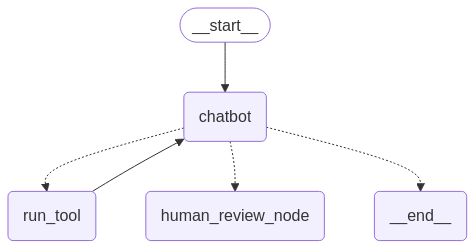

In [33]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [34]:
session_id = client.create_session()["sessionId"]
print("Using SessionId:", session_id)

Using SessionId: c5cf07de-4bbb-4bb0-a8af-b85d64d11b96


In [36]:
initial_input = {"messages": [{"role": "user", "content": "Can you help me buy running shoes"}]}

thread = {"configurable": {"thread_id": session_id}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

{'chatbot': {'messages': [AIMessage(content=[{'type': 'text', 'text': "Absolutely, I can help you find some great running shoes! To narrow down the options, I have a few questions:\n\n1. What is the primary surface you'll be running on - roads, trails, treadmill?\n\n2. Do you have any specific requirements like extra cushioning, motion control, or a particular heel-to-toe drop?\n\n3. Are you looking for lightweight racing flats or shoes with more support and durability for higher mileage?\n\n4. Do you have any brand preferences or have you had good experiences with certain running shoe models in the past?"}, {'type': 'tool_use', 'name': 'search_shoes', 'input': {'preference': 'running'}, 'id': 'tooluse_MPJnMErrQ9C1n3hxlL53Bg'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '3a472d0f-5723-4621-be3b-f2ccb723f6f6', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 10 Mar 2025 15:03:41 GMT', 'content-type': 'application/json', 'content-length': '840', 'conn

In [37]:
for event in graph.stream(
    # provide value
    Command(resume={"action": "continue"}),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")

{'human_review_node': None}


{'run_tool': {'messages': [{'role': 'tool', 'name': 'search_shoes', 'content': [(2, 'New Balance Running Off', 'New Balance', 'Running', 'Cushioning, Stability', 121.42, 8.0, 'Gainsboro', 40), (4, 'Nike Running Father', 'Nike', 'Running', 'Lightweight, Stability, Breathable', 104.57, 9.2, 'MediumTurquoise', 13), (19, 'Nike Running Require', 'Nike', 'Running', 'Cushioning, Breathable, Stability', 176.51, 8.9, 'NavajoWhite', 42), (21, 'Adidas Running Window', 'Adidas', 'Running', 'Stability, Lightweight, Breathable, Cushioning', 170.13, 8.5, 'DarkGoldenRod', 44), (23, 'Nike Running Test', 'Nike', 'Running', 'Stability, Lightweight, Cushioning, Breathable', 82.53, 12.6, 'LightSlateGray', 47), (27, 'Asics Running Possible', 'Asics', 'Running', 'Breathable, Cushioning', 189.83, 6.4, 'HotPink', 0), (28, 'Adidas Running Expect', 'Adidas', 'Running', 'Lightweight, Breathable, Stability', 132.07, 12.9, 'Azure', 45), (32, 'Asics Running Clearly', 'Asics', 'Running',